# Simulation

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from scipy.special import expit
from sklearn.preprocessing import StandardScaler

def generate_iv_data(n_samples=10000, n_covariates=100, seed=42):
    np.random.seed(seed)
    
    # Generate unmeasured confounders (U)
    U1 = np.random.normal(0, 1, n_samples)
    U2 = np.random.normal(0, 1, n_samples)
    
    # Generate instrumental variable (Z) related to confounders
    Z = 0.2*U1 + 0.2*U2 + np.random.normal(0, 1, n_samples)
    
    # Generate high-dimensional covariates
    # Make first 10 covariates related to outcome
    X = np.random.multivariate_normal(
        mean=np.zeros(n_covariates),
        cov=np.eye(n_covariates),
        size=n_samples
    )
    
    # Generate treatment (T) - categorical 1-6
    # Using ordered logit model
    T_linear = (1.5*Z +  # Strong IV effect
                0.4*U1 + 0.4*U2 +  # Moderate confounding
                0.3*X[:, 0] + 0.3*X[:, 1] + 
                np.random.normal(0, 0.5, n_samples))
    
    # Create cutpoints for categories
    cutpoints = np.array([-np.inf, -1, 0, 0.5, 1, 2, np.inf])

    T = np.zeros(n_samples)
    for i in range(1, 7):
        T += i * ((T_linear >= cutpoints[i-1]) & (T_linear < cutpoints[i]))
    
    Y_prob = expit(
        # More distinctive treatment effects with larger spread
        -0.5 +  # baseline intercept
        0.5*(T == 2) +    # small positive effect
        1.5*(T == 3) +    # moderate positive effect
        -3.0*(T == 4) +   # negative effect
        2.0*(T == 5) +    # large positive effect
        3.5*(T == 6) +    # very large positive effect
        
        # Reduced confounder effects to be more realistic
        0.3*U1 + 0.3*U2 +  # Moderate confounder main effects
        0.1*U1*T +  # Weaker interaction with treatment
        
        # Stronger covariate effects to balance reduced confounding
        0.5*X[:, 0] + 0.5*X[:, 1] + 0.4*X[:, 2] + 0.4*X[:, 3] + 0.3*X[:, 4] +
        0.3*X[:, 5] + 0.3*X[:, 6] + 0.2*X[:, 7] + 0.2*X[:, 8] + 0.2*X[:, 9]
    )
    Y = (np.random.random(n_samples) < Y_prob).astype(int)
    
    # Create dataframe
    df = pd.DataFrame(X, columns=[f'X{i+1}' for i in range(n_covariates)])
    df['Z'] = Z  # Instrumental variable
    df['T'] = T.astype(int)  # Treatment
    df['Y'] = Y  # Outcome
    
    # # Standardize all continuous variables
    # scaler = StandardScaler()
    # continuous_cols = [col for col in df.columns if col not in ['T', 'Y']]
    # df[continuous_cols] = scaler.fit_transform(df[continuous_cols])
    
    return df, U1, U2

def calculate_ate(data, alpha=0.05):
    treatments = sorted(data['T'].unique())
    results = []
    
    for t1 in treatments:
        for t2 in treatments:
            if t1 >= t2:
                continue
                
            # Get outcomes for each treatment group
            y1 = data[data['T'] == t1]['Y']
            y2 = data[data['T'] == t2]['Y']
            
            # Calculate means
            mean1 = np.mean(y1)
            mean2 = np.mean(y2)
            
            # Calculate ATE
            ate = mean2 - mean1
            
            # Calculate standard error
            n1, n2 = len(y1), len(y2)
            p1, p2 = mean1, mean2
            se = np.sqrt((p1 * (1-p1) / n1) + (p2 * (1-p2) / n2))
            
            # Calculate confidence intervals
            z_score = stats.norm.ppf(1 - alpha/2)
            ci_lower = ate - z_score * se
            ci_upper = ate + z_score * se
            
            # Calculate p-value
            z_stat = ate / se
            p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
            
            results.append({
                'Treatment1': t1,
                'Treatment2': t2,
                'ATE': ate,
                'SE': se,
                'CI_Lower': ci_lower,
                'CI_Upper': ci_upper,
                'P_value': p_value,
                'N1': n1,
                'N2': n2
            })
    
    return pd.DataFrame(results)

def validate_iv_assumptions(data, U1, U2, verbose=True):
    results = {}
    
    # 1. Relevance condition (Z->T relationship)
    first_stage = sm.OLS(data['T'], sm.add_constant(data['Z'])).fit()
    f_stat = first_stage.fvalue
    results['First Stage F-stat'] = f_stat
    results['Z-T correlation'] = stats.pearsonr(data['Z'], data['T'])[0]
    
    # 2. Exclusion restriction (Z-Y relationship)
    reduced_form = sm.OLS(data['Y'], sm.add_constant(data['Z'])).fit()
    results['Z-Y correlation'] = stats.pearsonr(data['Z'], data['Y'])[0]
    results['Z-Y p-value'] = reduced_form.pvalues[1]
    
    # 3. Treatment-Outcome relationship
    results['T-Y correlation'] = stats.pearsonr(data['T'], data['Y'])[0]
    
    # 4. Z-U correlations (for validation purposes only)
    results['Z-U1 correlation'] = stats.pearsonr(data['Z'], U1)[0]
    results['Z-U2 correlation'] = stats.pearsonr(data['Z'], U2)[0]
    
    if verbose:
        print("\nIV Validation Results:")
        print(f"First Stage F-statistic: {f_stat:.2f}")
        print(f"Z-T correlation: {results['Z-T correlation']:.3f}")
        print(f"Z-Y correlation: {results['Z-Y correlation']:.3f}")
        print(f"T-Y correlation: {results['T-Y correlation']:.3f}")
        print(f"Z-U1 correlation: {results['Z-U1 correlation']:.3f}")
        print(f"Z-U2 correlation: {results['Z-U2 correlation']:.3f}")
        
        if f_stat < 10:
            print("\nWarning: Weak instrument (F < 10)")
            
    return results

if __name__ == "__main__":
    # Generate data
    data, U1, U2 = generate_iv_data(n_samples=10000, n_covariates=100)
    data.to_csv('./sim_data.csv', index=False)
    print("Simulated data saved to sim_data.csv")
    
    # Validate IV assumptions
    print("\nValidating IV assumptions...")
    validation_stats = validate_iv_assumptions(data, U1, U2)
    
    # Calculate ATEs
    print("\nCalculating Average Treatment Effects...")
    ate_results = calculate_ate(data)
    
    # Save ATE results
    ate_results.to_csv('./ate.csv', index=False)
    print("ATE results saved to ate_results.csv")

    print("\nAnalysis complete!")

Simulated data saved to sim_data.csv

Validating IV assumptions...

IV Validation Results:
First Stage F-statistic: 22137.93
Z-T correlation: 0.830
Z-Y correlation: 0.302
T-Y correlation: 0.407
Z-U1 correlation: 0.217
Z-U2 correlation: 0.216

Calculating Average Treatment Effects...
ATE results saved to ate_results.csv

Analysis complete!


/var/folders/ph/fq9m_psn4bb_q7nfy97x754h0000gn/T/ipykernel_95263/593629327.py:132: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results['Z-Y p-value'] = reduced_form.pvalues[1]


## Calculate ATE estimates
### Multiple Comparison

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

var_names_config = {
    # Treatment regression config
    "treatReg_unused_vars": ['stay_id', 'caregiver_id', 'subject_id'],  # Variables to remove
    "treatReg_label_var": 'primary_vp', # Treatment variable
    "iv_label_var": 'hhi', # IV variable
    
    # Outcome regression config
    "outReg_unused_vars": ['stay_id', 'caregiver_id', 'subject_id', 'hhi', 's1', 't_pred'],  # Variables to remove (including IV)
    "outReg_label_var": "mortality",  # Outcome variable
    "outcome_pred_var": "predicted_mortality"
}

color_palette = ['#90BC95', '#59858B', '#6A92C2', '#D3D3D3', '#A9CA9E', '#D7DEC0']

def analyze_treatment_effects(data_path, var_names_config, method_name, alpha=0.05):
    df = pd.read_csv(data_path)
    
    treat_var = var_names_config['treatReg_label_var']
    outcome_var = var_names_config['outcome_pred_var']
    
    treatments = sorted(df[treat_var].unique())
    print(f"\nAnalyzing {method_name} dataset with {len(treatments)} treatments: {treatments}")
    
    results = []
    
    for i, treatment1 in enumerate(treatments):
        for j, treatment2 in enumerate(treatments):
            if i >= j:
                continue
                
            outcomes1 = df[df[treat_var] == treatment1][outcome_var]
            outcomes2 = df[df[treat_var] == treatment2][outcome_var]
            
            mean1 = outcomes1.mean()
            mean2 = outcomes2.mean()
            std1 = outcomes1.std()
            std2 = outcomes2.std()
            n1 = len(outcomes1)
            n2 = len(outcomes2)
            
            ate = mean2 - mean1
            t_stat, p_value = stats.ttest_ind(outcomes2, outcomes1, equal_var=False)
            se_diff = np.sqrt((std2**2 / n2) + (std1**2 / n1))
            
            df_welch = ((se_diff**2)**2) / (
                (std2**4 / (n2**2 * (n2-1))) +
                (std1**4 / (n1**2 * (n1-1)))
            )
            
            ci_lower = ate - stats.t.ppf(1-alpha/2, df_welch) * se_diff
            ci_upper = ate + stats.t.ppf(1-alpha/2, df_welch) * se_diff
            
            results.append({
                'Method': method_name,
                'Treatment1': treatment1,
                'Treatment2': treatment2,
                'Mean1': mean1,
                'Mean2': mean2,
                'Std1': std1,
                'Std2': std2,
                'N1': n1,
                'N2': n2,
                'ATE': ate,
                'SE': se_diff,
                'P_Value': p_value,
                'CI_Lower': ci_lower,
                'CI_Upper': ci_upper,
                'Significant': p_value < alpha
            })
    
    return pd.DataFrame(results)

def compare_methods_visualization(all_results, save_path=None):
    methods = all_results['Method'].unique()
    treatment_pairs = all_results[['Treatment1', 'Treatment2']].apply(
        lambda x: f"{x['Treatment2']} vs {x['Treatment1']}", axis=1).unique()
    
    # 1. Comparison plot of ATEs across methods
    plt.figure(figsize=(8, 6))
    
    x = np.arange(len(treatment_pairs))
    width = 0.22
    multiplier = 0
    
    # Use the first three colors for the methods
    for method, color in zip(methods, color_palette[:len(methods)]):
        method_data = all_results[all_results['Method'] == method]
        offset = width * multiplier
        rects = plt.bar(x + offset, method_data['ATE'], width, label=method, color=color)
        multiplier += 1
    
    plt.xlabel('Treatment Comparisons')
    plt.ylabel('Average Treatment Effect')
    plt.title('ATE Comparison Across Methods')
    plt.xticks(x + width * (len(methods)-1)/2, treatment_pairs, rotation=45)
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    
    if save_path:
        plt.savefig(save_path.replace('.png', '_comparison.png'), bbox_inches='tight')
    plt.close()
    
    # 2. Forest plot comparing confidence intervals
    plt.figure(figsize=(8, 6))
    
    y_positions = np.arange(len(treatment_pairs) * len(methods))
    labels = []
    ates = []
    ci_lowers = []
    ci_uppers = []
    colors = []
    
    for i, pair in enumerate(treatment_pairs):
        for j, method in enumerate(methods):
            mask = (all_results['Method'] == method) & \
                  (all_results.apply(lambda x: f"{x['Treatment2']} vs {x['Treatment1']}" == pair, axis=1))
            row = all_results[mask].iloc[0]
            labels.append(f"{pair} ({method})")
            ates.append(row['ATE'])
            ci_lowers.append(row['CI_Lower'])
            ci_uppers.append(row['CI_Upper'])
            colors.append(color_palette[j])  # Assign color based on method
    
    for i in range(len(ates)):
        plt.errorbar(ates[i], y_positions[i], 
                    xerr=[[ates[i] - ci_lowers[i]], [ci_uppers[i] - ates[i]]],
                    fmt='o', capsize=5, color=colors[i], linewidth=3)
    
    plt.axvline(x=0, color='#D3D3D3', linestyle='--', alpha=0.5, linewidth=2)
    plt.yticks(y_positions, labels)
    plt.xlabel('Average Treatment Effect')
    plt.title('Treatment Effects Comparison with Confidence Intervals')
    plt.grid(True, alpha=0.3)
    
    if save_path:
        plt.savefig(save_path.replace('.png', '_forest_comparison.png'), bbox_inches='tight')
    plt.close()

def visualize_treatment_effects(results, save_path=None):
    all_treatments = sorted(set(results['Treatment1'].unique()) | set(results['Treatment2'].unique()))
    n_treatments = len(all_treatments)

    # 1. Forest plot of pairwise comparisons
    plt.figure(figsize=(8, 6))
    
    y_positions = range(len(results))
    labels = [f"{row['Treatment2']} vs {row['Treatment1']}" for _, row in results.iterrows()]
    
    plt.errorbar(results['ATE'], y_positions,
                xerr=[results['ATE'] - results['CI_Lower'],
                      results['CI_Upper'] - results['ATE']], 
                fmt='o', capsize=5, color='#6A92C2', linewidth=3)
    
    plt.axvline(x=0, color='#D3D3D3', linestyle='--', alpha=0.5)
    plt.yticks(y_positions, labels)
    plt.xlabel('Average Treatment Effect')
    plt.title('Pairwise Treatment Effects')
    plt.grid(True, alpha=0.3)
    
    if save_path:
        plt.savefig(save_path.replace('.png', '_forest.png'), bbox_inches='tight')
    plt.close()
    
    # 2. Treatment means comparison
    plt.figure(figsize=(8, 6))
    
    means_data = []
    for treatment in all_treatments:
        means1 = results[results['Treatment1'] == treatment]['Mean1']
        means2 = results[results['Treatment2'] == treatment]['Mean2']
        if not means1.empty:
            mean_value = means1.iloc[0]
        else:
            mean_value = means2.iloc[0]
        means_data.append({'Treatment': treatment, 'Mean': mean_value})
    
    means_df = pd.DataFrame(means_data)
    sns.barplot(data=means_df, x='Treatment', y='Mean', palette=color_palette)
    plt.xlabel('Treatment')
    plt.ylabel('Mean Outcome')
    plt.title('Mean Outcomes by Treatment')
    
    if save_path:
        plt.savefig(save_path.replace('.png', '_means.png'), bbox_inches='tight')
    plt.close()
    
    # 3. Heatmap of treatment differences
    heatmap_data = np.zeros((n_treatments, n_treatments))
    
    for _, row in results.iterrows():
        i = all_treatments.index(row['Treatment1'])
        j = all_treatments.index(row['Treatment2'])
        heatmap_data[i, j] = row['ATE']
        heatmap_data[j, i] = -row['ATE']
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data, 
                xticklabels=all_treatments,
                yticklabels=all_treatments,
                center=0,
                cmap=sns.diverging_palette(220, 20, n=200),  # Using a custom diverging palette
                annot=True,
                fmt='.3f',
                cbar_kws={'shrink': 1})
    plt.title('Pairwise Treatment Effects')
    
    if save_path:
        summary_path = save_path.rsplit('.', 1)[0] + '_summary.csv'
        results.to_csv(summary_path, index=False)
        plt.savefig(save_path.replace('.png', '_heatmap.png'), bbox_inches='tight')
    plt.close()
    
# Analyze all three datasets
datasets = {
    'ALL': './real_outcome/ALL_data_with_mortality_predictions.csv',
    'LASSO': './real_outcome/LASSO_data_with_mortality_predictions.csv',
    'SPIKE': './real_outcome/SPIKE_data_with_mortality_predictions.csv',
    'BayeLASSO': './real_outcome/BaysianLASSO_real_data_with_mortality_predictions.csv'
}

all_results = []
for method, path in datasets.items():
    results = analyze_treatment_effects(path, var_names_config, method)
    all_results.append(results)

# Combine all results
combined_results = pd.concat(all_results, ignore_index=True)

# Save combined results
combined_results.to_csv('./real_outcome/228_ate_results_combined.csv', index=False)

# Create comparison visualizations
compare_methods_visualization(combined_results, './real_outcome/ate_comparison_plot.png')

# Can also still generate individual visualizations if needed
for method in datasets.keys():
    method_results = combined_results[combined_results['Method'] == method]
    visualize_treatment_effects(method_results, f'./real_outcome/ate_plot_{method.lower()}.png')


Analyzing ALL dataset with 3 treatments: ['norepinephrine', 'phenylephrine', 'vasopressin']

Analyzing LASSO dataset with 3 treatments: ['norepinephrine', 'phenylephrine', 'vasopressin']

Analyzing SPIKE dataset with 3 treatments: ['norepinephrine', 'phenylephrine', 'vasopressin']

Analyzing BayeLASSO dataset with 3 treatments: ['norepinephrine', 'phenylephrine', 'vasopressin']


##  Bayesian LASSO MIMIC-IV

In [1]:
import time
import numpy as np
import pandas as pd
import scipy.stats as stats
import pymc as pm
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def load_and_prepare_data(x_path, y_path):
    # Load the datasets
    X = pd.read_csv(x_path, header=None)
    y = pd.read_csv(y_path, header=None)

    # Generate feature names
    feature_names = [f'Feature_{i}' for i in range(X.shape[1])]
    
    # Convert boolean outcome to numeric
    def convert_to_numeric(val):
        if isinstance(val, bool):
            return 1 if val else 0
        if isinstance(val, str):
            return 1 if val.lower() == 'true' else 0
        return val
    
    y_numeric = y.iloc[:, 0].apply(convert_to_numeric)

    # Verify the conversion worked
    if y_numeric.isnull().any():
        raise ValueError("Failed to convert some y values to numeric")
    
    # Standardize features with extra checks
    X_values = X.values
    means = np.mean(X_values, axis=0)
    stds = np.std(X_values, axis=0)
    
    # Check for zero standard deviation
    zero_std = stds == 0
    if np.any(zero_std):
        print(f"Warning: {np.sum(zero_std)} features have zero standard deviation")
        # Replace zero stds with 1 to avoid division by zero
        stds[zero_std] = 1
    
    X_standardized = (X_values - means) / stds
    
    # Verify no NaN values after standardization
    if np.any(np.isnan(X_standardized)):
        raise ValueError("Standardization produced NaN values")
    
    print(f"\nData loaded successfully:")

    return X_standardized, y_numeric.values, feature_names

def bayesian_lasso(X, y, num_samples=2000, tune=1000, chains=4):
    n_features = X.shape[1]
    
    with pm.Model() as model:
        # Stronger regularization priors
        tau = pm.HalfCauchy('tau', beta=0.5)
        beta = pm.Normal('beta', mu=0, sigma=tau, shape=n_features)
        intercept = pm.Normal('intercept', mu=0, sigma=1)
        
        # Linear predictor with clipping
        eta = intercept + pm.math.dot(X, beta)
        eta_clipped = pm.math.clip(eta, -10, 10)  # Prevent extreme values
        p = pm.math.invlogit(eta_clipped)
        
        # Likelihood
        y_obs = pm.Bernoulli('y_obs', p=p, observed=y)
        
        # Try single-threaded sampling without MAP initialization
        trace = pm.sample(
            draws=num_samples,
            tune=tune,
            chains=chains,
            cores=1,  # Force single-threaded
            return_inferencedata=True,
            init='jitter+adapt_diag',
            target_accept=0.99,  # More conservative acceptance rate
            random_seed=42
        )
    
    return trace, model

def run_bayesian_lasso_implementation(x_path, y_path, num_samples=2000, tune=1000, chains=2, 
                                    save_prefix='bayesian_results'):
    start_time = time.time()

    print("Loading and preparing data...")
    X_standardized, y, feature_names = load_and_prepare_data(x_path, y_path)
    
    print("\nFitting Bayesian LASSO model...")
    trace, model = bayesian_lasso(X_standardized, y, num_samples, tune, chains)
    
    # Extract and save important information
    beta_samples = trace.posterior['beta'].values
    beta_mean = beta_samples.mean(axis=(0,1))
    beta_std = beta_samples.std(axis=(0,1))
    importance_score = np.abs(beta_mean) / beta_std
    
    # Create and save initial results DataFrame
    results_df = pd.DataFrame({
        'Feature': feature_names,
        'Mean_Coefficient': beta_mean,
        'Std_Coefficient': beta_std,
        'Importance_Score': importance_score
    })
    
    # Save results to CSV
    results_df.to_csv(f'{save_prefix}_initial.csv', index=False)
    
    print(f"\nResults saved to {save_prefix}_initial.csv")
    print(f"Actual runtime: {timedelta(seconds=int(time.time() - start_time))}")
    
    return results_df, trace

if __name__ == "__main__":
    # Step 1: Run the model and get results
    results_df, trace = run_bayesian_lasso_implementation(
        x_path='X_second_processed.csv',
        y_path='y_second.csv',
        save_prefix='bayesian_results'
    )

Loading and preparing data...

Data loaded successfully:

Fitting Bayesian LASSO model...


Auto-assigning NUTS sampler...
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.10 is maybe too old for this OS.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [tau, beta, intercept]


Output()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.10 is maybe too old for this OS.
  warnings.warn(


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 40597 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



Results saved to bayesian_results_initial.csv
Actual runtime: 11:16:40


In [2]:
def create_diagnostic_plots(trace, save_prefix='diagnostic'):
    # 1. Trace plots for main parameters
    az.plot_trace(trace, var_names=['tau', 'intercept'])
    plt.tight_layout()
    plt.savefig(f'{save_prefix}_trace_main.png')
    plt.close()
    
    # 2. Print R-hat values instead of plotting
    rhat = az.rhat(trace)
    print("\nR-hat Values (Should be close to 1):")
    for var_name, value in rhat.items():
        if var_name != 'y_obs':  # Skip the observed data
            if value.size > 1:  # For vector parameters like beta
                print(f"{var_name} range: {value.min():.3f} to {value.max():.3f}")
            else:  # For scalar parameters like tau and intercept
                print(f"{var_name}: {float(value):.3f}")
    
    # 3. Autocorrelation plot for main parameters
    az.plot_autocorr(trace, var_names=['tau', 'intercept'])
    plt.tight_layout()
    plt.savefig(f'{save_prefix}_autocorr.png')
    plt.close()
    
    # 4. Posterior distributions for top coefficients
    az.plot_posterior(trace, var_names=['beta'][:5])  # Plot first 5 betas
    plt.tight_layout()
    plt.savefig(f'{save_prefix}_posterior.png')
    plt.close()
    
    # 5. Forest plot for top coefficients
    az.plot_forest(trace, var_names=['beta'][:10])  # Plot first 10 betas
    plt.title('Forest Plot of Top 10 Coefficients')
    plt.tight_layout()
    plt.savefig(f'{save_prefix}_forest.png')
    plt.close()
    
    # Print summary statistics
    summary = az.summary(trace, var_names=['tau', 'intercept'])
    print("\nModel Summary Statistics:")
    print(summary)
    
    return summary

def plot_detailed_coefficients(trace, feature_names, save_path='coefficient_analysis.png'):
    """
    Create a detailed coefficient analysis plot
    """
    beta_samples = trace.posterior['beta'].values
    beta_mean = beta_samples.mean(axis=(0,1))
    beta_std = beta_samples.std(axis=(0,1))
    
    # Sort by absolute mean value
    indices = np.argsort(np.abs(beta_mean))[::-1][:10]  # Top 10 coefficients
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    # Coefficient plot
    ax1.errorbar(beta_mean[indices], 
                range(len(indices)),
                xerr=2*beta_std[indices],
                fmt='o',
                capsize=5)
    ax1.set_yticks(range(len(indices)))
    ax1.set_yticklabels([feature_names[i] for i in indices])
    ax1.axvline(x=0, color='red', linestyle='--', alpha=0.5)
    ax1.set_title('Top 10 Coefficients with 95% Credible Intervals')
    
    # Density plot for top 3 coefficients
    for i in indices[:3]:
        sns.kdeplot(beta_samples[:,:,i].flatten(), 
                   ax=ax2,
                   label=feature_names[i])
    ax2.axvline(x=0, color='red', linestyle='--', alpha=0.5)
    ax2.set_title('Posterior Distributions of Top 3 Coefficients')
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

def analyze_and_plot_results(results_df, trace, percentile_threshold=75, save_prefix='analysis'):
    # Calculate percentile threshold
    importance_threshold = np.percentile(results_df['Importance_Score'], 100 - percentile_threshold)
    selected_features = results_df['Importance_Score'] >= importance_threshold
    
    # Add HDI intervals
    beta_hdi = az.hdi(trace, var_names=['beta'])
    results_df['HDI_Lower'] = beta_hdi['beta'][:,0]
    results_df['HDI_Upper'] = beta_hdi['beta'][:,1]
    results_df['Selected'] = selected_features
    
    # Sort by importance score
    results_df = results_df.sort_values('Importance_Score', ascending=False)
    
    # Save results
    results_df.to_csv(f'{save_prefix}_results.csv', index=False)
    
    # Create diagnostic plots
    create_diagnostic_plots(trace, save_prefix=save_prefix)
    
    # Create detailed coefficient plot
    plot_detailed_coefficients(trace, results_df['Feature'].tolist(), 
                             save_path=f'{save_prefix}_selected_features.png')
    
    print("\nAnalysis Summary:")
    print(f"Total features: {len(results_df)}")
    print(f"Selected features ({percentile_threshold}th percentile): {sum(selected_features)}")
    print("\nTop 10 features by importance:")
    print(results_df[['Feature', 'Mean_Coefficient', 'Importance_Score', 'Selected']].head(10))
    
    return results_df

# File 2: analyze_results.py
if __name__ == "__main__":
    # Load results and trace
    results_df = pd.read_csv('bayesian_results_initial.csv')
    
    # Step 2: Analyze results with different percentile thresholds
    final_results = analyze_and_plot_results(
        results_df,
        trace,
        percentile_threshold=75,
        save_prefix='analysis_75percentile'
    )


R-hat Values (Should be close to 1):
beta range: 1.000 to 1.003
intercept: 1.001
tau: 1.000


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (120) in plot_posterior, generating only 40 plots
  warnings.warn(



Model Summary Statistics:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tau        0.711  0.059   0.603    0.820      0.001    0.001    2933.0   
intercept -2.720  0.130  -2.958   -2.478      0.002    0.001    6257.0   

           ess_tail  r_hat  
tau          2893.0    1.0  
intercept    2924.0    1.0  


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):



Analysis Summary:
Total features: 120
Selected features (75th percentile): 90

Top 10 features by importance:
       Feature  Mean_Coefficient  Importance_Score  Selected
5    Feature_5         -4.875713         28.684299      True
3    Feature_3          3.777489         24.923551      True
4    Feature_4         -2.177223         21.135536      True
74  Feature_74         -0.250052          3.137934      True
14  Feature_14          0.412734          2.617103      True
22  Feature_22         -0.349911          2.440054      True
83  Feature_83         -0.165104          2.173659      True
10  Feature_10          0.206764          2.003518      True
72  Feature_72         -0.147551          1.937026      True
16  Feature_16         -0.181063          1.723075      True


## BayesLASSO simulation

In [8]:
import time
import numpy as np
import pandas as pd
import scipy.stats as stats
import pymc as pm
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def load_and_prepare_data(x_path, y_path):
    # Load the datasets
    X = pd.read_csv(x_path, header=None)
    y = pd.read_csv(y_path, header=None)

    # Generate feature names
    feature_names = [f'Feature_{i}' for i in range(X.shape[1])]
    
    # Convert boolean outcome to numeric
    def convert_to_numeric(val):
        if isinstance(val, bool):
            return 1 if val else 0
        if isinstance(val, str):
            return 1 if val.lower() == 'true' else 0
        return val
    
    y_numeric = y.iloc[:, 0].apply(convert_to_numeric)

    # Verify the conversion worked
    if y_numeric.isnull().any():
        raise ValueError("Failed to convert some y values to numeric")
    
    # Standardize features with extra checks
    X_values = X.values
    means = np.mean(X_values, axis=0)
    stds = np.std(X_values, axis=0)
    
    # Check for zero standard deviation
    zero_std = stds == 0
    if np.any(zero_std):
        print(f"Warning: {np.sum(zero_std)} features have zero standard deviation")
        # Replace zero stds with 1 to avoid division by zero
        stds[zero_std] = 1
    
    X_standardized = (X_values - means) / stds
    
    # Verify no NaN values after standardization
    if np.any(np.isnan(X_standardized)):
        raise ValueError("Standardization produced NaN values")
    
    print(f"\nData loaded successfully:")

    return X_standardized, y_numeric.values, feature_names

def bayesian_lasso(X, y, num_samples=2000, tune=1000, chains=4):
    n_features = X.shape[1]
    
    with pm.Model() as model:
        # Stronger regularization priors
        tau = pm.HalfCauchy('tau', beta=0.5)
        beta = pm.Normal('beta', mu=0, sigma=tau, shape=n_features)
        intercept = pm.Normal('intercept', mu=0, sigma=1)
        
        # Linear predictor with clipping
        eta = intercept + pm.math.dot(X, beta)
        eta_clipped = pm.math.clip(eta, -10, 10)  # Prevent extreme values
        p = pm.math.invlogit(eta_clipped)
        
        # Likelihood
        y_obs = pm.Bernoulli('y_obs', p=p, observed=y)
        
        # Try single-threaded sampling without MAP initialization
        trace = pm.sample(
            draws=num_samples,
            tune=tune,
            chains=chains,
            cores=1,  # Force single-threaded
            return_inferencedata=True,
            init='jitter+adapt_diag',
            target_accept=0.99,  # More conservative acceptance rate
            random_seed=42
        )
    
    return trace, model

def run_bayesian_lasso_implementation(x_path, y_path, num_samples=2000, tune=1000, chains=2, 
                                    save_prefix='bayesian_results'):
    start_time = time.time()

    print("Loading and preparing data...")
    X_standardized, y, feature_names = load_and_prepare_data(x_path, y_path)
    
    print("\nFitting Bayesian LASSO model...")
    trace, model = bayesian_lasso(X_standardized, y, num_samples, tune, chains)
    
    # Extract and save important information
    beta_samples = trace.posterior['beta'].values
    beta_mean = beta_samples.mean(axis=(0,1))
    beta_std = beta_samples.std(axis=(0,1))
    importance_score = np.abs(beta_mean) / beta_std
    
    # Create and save initial results DataFrame
    results_df = pd.DataFrame({
        'Feature': feature_names,
        'Mean_Coefficient': beta_mean,
        'Std_Coefficient': beta_std,
        'Importance_Score': importance_score
    })
    
    # Save results to CSV
    results_df.to_csv(f'{save_prefix}_initial.csv', index=False)
    
    print(f"\nResults saved to {save_prefix}_initial.csv")
    print(f"Actual runtime: {timedelta(seconds=int(time.time() - start_time))}")
    
    return results_df, trace

if __name__ == "__main__":
    # Step 1: Run the model and get results
    results_df, trace = run_bayesian_lasso_implementation(
        x_path='./simulation/X_second_processed_sim.csv',
        y_path='./simulation/y_second_sim.csv',
        save_prefix='./simulation/bayesian_sim_results'
    )

Loading and preparing data...

Data loaded successfully:

Fitting Bayesian LASSO model...


Auto-assigning NUTS sampler...
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.10 is maybe too old for this OS.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [tau, beta, intercept]


Output()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.10 is maybe too old for this OS.
  warnings.warn(


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 284 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



Results saved to ./simulation/bayesian_sim_results_initial.csv
Actual runtime: 0:04:45


In [9]:
def create_diagnostic_plots(trace, save_prefix='diagnostic'):
    # 1. Trace plots for main parameters
    az.plot_trace(trace, var_names=['tau', 'intercept'])
    plt.tight_layout()
    plt.savefig(f'{save_prefix}_trace_main.png')
    plt.close()
    
    # 2. Print R-hat values instead of plotting
    rhat = az.rhat(trace)
    print("\nR-hat Values (Should be close to 1):")
    for var_name, value in rhat.items():
        if var_name != 'y_obs':  # Skip the observed data
            if value.size > 1:  # For vector parameters like beta
                print(f"{var_name} range: {value.min():.3f} to {value.max():.3f}")
            else:  # For scalar parameters like tau and intercept
                print(f"{var_name}: {float(value):.3f}")
    
    # 3. Autocorrelation plot for main parameters
    az.plot_autocorr(trace, var_names=['tau', 'intercept'])
    plt.tight_layout()
    plt.savefig(f'{save_prefix}_autocorr.png')
    plt.close()
    
    # 4. Posterior distributions for top coefficients
    az.plot_posterior(trace, var_names=['beta'][:5])  # Plot first 5 betas
    plt.tight_layout()
    plt.savefig(f'{save_prefix}_posterior.png')
    plt.close()
    
    # 5. Forest plot for top coefficients
    az.plot_forest(trace, var_names=['beta'][:10])  # Plot first 10 betas
    plt.title('Forest Plot of Top 10 Coefficients')
    plt.tight_layout()
    plt.savefig(f'{save_prefix}_forest.png')
    plt.close()
    
    # Print summary statistics
    summary = az.summary(trace, var_names=['tau', 'intercept'])
    print("\nModel Summary Statistics:")
    print(summary)
    
    return summary

def plot_detailed_coefficients(trace, feature_names, save_path='coefficient_analysis.png'):
    """
    Create a detailed coefficient analysis plot
    """
    beta_samples = trace.posterior['beta'].values
    beta_mean = beta_samples.mean(axis=(0,1))
    beta_std = beta_samples.std(axis=(0,1))
    
    # Sort by absolute mean value
    indices = np.argsort(np.abs(beta_mean))[::-1][:10]  # Top 10 coefficients
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    # Coefficient plot
    ax1.errorbar(beta_mean[indices], 
                range(len(indices)),
                xerr=2*beta_std[indices],
                fmt='o',
                capsize=5)
    ax1.set_yticks(range(len(indices)))
    ax1.set_yticklabels([feature_names[i] for i in indices])
    ax1.axvline(x=0, color='red', linestyle='--', alpha=0.5)
    ax1.set_title('Top 10 Coefficients with 95% Credible Intervals')
    
    # Density plot for top 3 coefficients
    for i in indices[:3]:
        sns.kdeplot(beta_samples[:,:,i].flatten(), 
                   ax=ax2,
                   label=feature_names[i])
    ax2.axvline(x=0, color='red', linestyle='--', alpha=0.5)
    ax2.set_title('Posterior Distributions of Top 3 Coefficients')
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

def analyze_and_plot_results(results_df, trace, percentile_threshold=75, save_prefix='analysis'):
    # Calculate percentile threshold
    importance_threshold = np.percentile(results_df['Importance_Score'], 100 - percentile_threshold)
    selected_features = results_df['Importance_Score'] >= importance_threshold
    
    # Add HDI intervals
    beta_hdi = az.hdi(trace, var_names=['beta'])
    results_df['HDI_Lower'] = beta_hdi['beta'][:,0]
    results_df['HDI_Upper'] = beta_hdi['beta'][:,1]
    results_df['Selected'] = selected_features
    
    # Sort by importance score
    results_df = results_df.sort_values('Importance_Score', ascending=False)
    
    # Save results
    results_df.to_csv(f'{save_prefix}_results.csv', index=False)
    
    # Create diagnostic plots
    create_diagnostic_plots(trace, save_prefix=save_prefix)
    
    # Create detailed coefficient plot
    plot_detailed_coefficients(trace, results_df['Feature'].tolist(), 
                             save_path=f'{save_prefix}_selected_features.png')
    
    print("\nAnalysis Summary:")
    print(f"Total features: {len(results_df)}")
    print(f"Selected features ({percentile_threshold}th percentile): {sum(selected_features)}")
    print("\nTop 10 features by importance:")
    print(results_df[['Feature', 'Mean_Coefficient', 'Importance_Score', 'Selected']].head(10))
    
    return results_df

# File 2: analyze_results.py
if __name__ == "__main__":
    # Load results and trace
    results_df = pd.read_csv('./simulation/bayesian_sim_results_initial.csv')
    
    # Step 2: Analyze results with different percentile thresholds
    final_results = analyze_and_plot_results(
        results_df,
        trace,
        percentile_threshold=75,
        save_prefix='./simulation/analysis_75percentile_sim'
    )


R-hat Values (Should be close to 1):
beta range: 1.000 to 1.006
intercept: 1.000
tau: 1.002


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (112) in plot_posterior, generating only 40 plots
  warnings.warn(



Model Summary Statistics:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tau        0.168  0.013   0.145    0.192        0.0      0.0    4623.0   
intercept  0.257  0.028   0.205    0.308        0.0      0.0    7133.0   

           ess_tail  r_hat  
tau          2781.0    1.0  
intercept    2841.0    1.0  


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):



Analysis Summary:
Total features: 112
Selected features (75th percentile): 84

Top 10 features by importance:
         Feature  Mean_Coefficient  Importance_Score  Selected
0      Feature_0          0.452167         17.338964      True
1      Feature_1          0.402116         15.129931      True
2      Feature_2          0.402076         14.911251      True
109  Feature_109         -0.807736         13.464050      True
3      Feature_3          0.311765         11.983137      True
6      Feature_6          0.297978         11.300212      True
5      Feature_5          0.269845         10.422888      True
4      Feature_4          0.261133         10.204287      True
111  Feature_111          0.844331          9.974813      True
9      Feature_9          0.189655          7.494399      True


### Simulation Comparison

In [10]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

var_names_config = {
    # Treatment regression config
    "treatReg_unused_vars": ['stay_id', 'caregiver_id', 'subject_id'],  # Variables to remove
    "treatReg_label_var": 'T', #primary_vp # Treatment variable
    "iv_label_var": 'Z', # hhi  # IV variable
    
    # Outcome regression config
    "outReg_unused_vars": ['stay_id', 'caregiver_id', 'subject_id', 'hhi', 's1', 'Z', 't_pred'],  # Variables to remove (including IV)
    # "outReg_label_var": "mortality",  # Outcome variable
    "outcome_pred_var": "predicted_mortality"
}

color_palette = ['#90BC95', '#59858B', '#6A92C2', '#D3D3D3', '#A9CA9E', '#D7DEC0']

def analyze_treatment_effects(data_path, var_names_config, method_name, alpha=0.05):
    df = pd.read_csv(data_path)
    
    treat_var = var_names_config['treatReg_label_var']
    outcome_var = var_names_config['outcome_pred_var']
    
    treatments = sorted(df[treat_var].unique())
    print(f"\nAnalyzing {method_name} dataset with {len(treatments)} treatments: {treatments}")
    
    results = []
    
    for i, treatment1 in enumerate(treatments):
        for j, treatment2 in enumerate(treatments):
            if i >= j:
                continue
                
            outcomes1 = df[df[treat_var] == treatment1][outcome_var]
            outcomes2 = df[df[treat_var] == treatment2][outcome_var]
            
            mean1 = outcomes1.mean()
            mean2 = outcomes2.mean()
            std1 = outcomes1.std()
            std2 = outcomes2.std()
            n1 = len(outcomes1)
            n2 = len(outcomes2)
            
            ate = mean2 - mean1
            t_stat, p_value = stats.ttest_ind(outcomes2, outcomes1, equal_var=False)
            se_diff = np.sqrt((std2**2 / n2) + (std1**2 / n1))
            
            df_welch = ((se_diff**2)**2) / (
                (std2**4 / (n2**2 * (n2-1))) +
                (std1**4 / (n1**2 * (n1-1)))
            )
            
            ci_lower = ate - stats.t.ppf(1-alpha/2, df_welch) * se_diff
            ci_upper = ate + stats.t.ppf(1-alpha/2, df_welch) * se_diff
            
            results.append({
                'Method': method_name,
                'Treatment1': treatment1,
                'Treatment2': treatment2,
                'Mean1': mean1,
                'Mean2': mean2,
                'Std1': std1,
                'Std2': std2,
                'N1': n1,
                'N2': n2,
                'ATE': ate,
                'SE': se_diff,
                'P_Value': p_value,
                'CI_Lower': ci_lower,
                'CI_Upper': ci_upper,
                'Significant': p_value < alpha
            })
    
    return pd.DataFrame(results)

def compare_methods_visualization(all_results, save_path=None):
    methods = all_results['Method'].unique()
    treatment_pairs = all_results[['Treatment1', 'Treatment2']].apply(
        lambda x: f"{x['Treatment2']} vs {x['Treatment1']}", axis=1).unique()
    
    # 1. Comparison plot of ATEs across methods
    plt.figure(figsize=(8, 6))
    
    x = np.arange(len(treatment_pairs))
    width = 0.22
    multiplier = 0
    
    # Use the first three colors for the methods
    for method, color in zip(methods, color_palette[:len(methods)]):
        method_data = all_results[all_results['Method'] == method]
        offset = width * multiplier
        rects = plt.bar(x + offset, method_data['ATE'], width, label=method, color=color)
        multiplier += 1
    
    plt.xlabel('Treatment Comparisons')
    plt.ylabel('Average Treatment Effect')
    plt.title('ATE Comparison Across Methods')
    plt.xticks(x + width * (len(methods)-1)/2, treatment_pairs, rotation=45)
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    
    if save_path:
        plt.savefig(save_path.replace('.png', '_comparison.png'), bbox_inches='tight')
    plt.close()
    
    # 2. Forest plot comparing confidence intervals
    plt.figure(figsize=(8, 6))
    
    y_positions = np.arange(len(treatment_pairs) * len(methods))
    labels = []
    ates = []
    ci_lowers = []
    ci_uppers = []
    colors = []
    
    for i, pair in enumerate(treatment_pairs):
        for j, method in enumerate(methods):
            mask = (all_results['Method'] == method) & \
                  (all_results.apply(lambda x: f"{x['Treatment2']} vs {x['Treatment1']}" == pair, axis=1))
            row = all_results[mask].iloc[0]
            labels.append(f"{pair} ({method})")
            ates.append(row['ATE'])
            ci_lowers.append(row['CI_Lower'])
            ci_uppers.append(row['CI_Upper'])
            colors.append(color_palette[j])  # Assign color based on method
    
    for i in range(len(ates)):
        plt.errorbar(ates[i], y_positions[i], 
                    xerr=[[ates[i] - ci_lowers[i]], [ci_uppers[i] - ates[i]]],
                    fmt='o', capsize=5, color=colors[i], linewidth=3)
    
    plt.axvline(x=0, color='#D3D3D3', linestyle='--', alpha=0.5, linewidth=2)
    plt.yticks(y_positions, labels)
    plt.xlabel('Average Treatment Effect')
    plt.title('Treatment Effects Comparison with Confidence Intervals')
    plt.grid(True, alpha=0.3)
    
    if save_path:
        plt.savefig(save_path.replace('.png', '_forest_comparison.png'), bbox_inches='tight')
    plt.close()

def visualize_treatment_effects(results, save_path=None):
    all_treatments = sorted(set(results['Treatment1'].unique()) | set(results['Treatment2'].unique()))
    n_treatments = len(all_treatments)

    # 1. Forest plot of pairwise comparisons
    plt.figure(figsize=(8, 6))
    
    y_positions = range(len(results))
    labels = [f"{row['Treatment2']} vs {row['Treatment1']}" for _, row in results.iterrows()]
    
    plt.errorbar(results['ATE'], y_positions,
                xerr=[results['ATE'] - results['CI_Lower'],
                      results['CI_Upper'] - results['ATE']], 
                fmt='o', capsize=5, color='#6A92C2', linewidth=3)
    
    plt.axvline(x=0, color='#D3D3D3', linestyle='--', alpha=0.5)
    plt.yticks(y_positions, labels)
    plt.xlabel('Average Treatment Effect')
    plt.title('Pairwise Treatment Effects')
    plt.grid(True, alpha=0.3)
    
    if save_path:
        plt.savefig(save_path.replace('.png', '_forest.png'), bbox_inches='tight')
    plt.close()
    
    # 2. Treatment means comparison
    plt.figure(figsize=(8, 6))
    
    means_data = []
    for treatment in all_treatments:
        means1 = results[results['Treatment1'] == treatment]['Mean1']
        means2 = results[results['Treatment2'] == treatment]['Mean2']
        if not means1.empty:
            mean_value = means1.iloc[0]
        else:
            mean_value = means2.iloc[0]
        means_data.append({'Treatment': treatment, 'Mean': mean_value})
    
    means_df = pd.DataFrame(means_data)
    sns.barplot(data=means_df, x='Treatment', y='Mean', palette=color_palette)
    plt.xlabel('Treatment')
    plt.ylabel('Mean Outcome')
    plt.title('Mean Outcomes by Treatment')
    
    if save_path:
        plt.savefig(save_path.replace('.png', '_means.png'), bbox_inches='tight')
    plt.close()
    
    # 3. Heatmap of treatment differences
    heatmap_data = np.zeros((n_treatments, n_treatments))
    
    for _, row in results.iterrows():
        i = all_treatments.index(row['Treatment1'])
        j = all_treatments.index(row['Treatment2'])
        heatmap_data[i, j] = row['ATE']
        heatmap_data[j, i] = -row['ATE']
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data, 
                xticklabels=all_treatments,
                yticklabels=all_treatments,
                center=0,
                cmap=sns.diverging_palette(220, 20, n=200),  # Using a custom diverging palette
                annot=True,
                fmt='.3f',
                cbar_kws={'shrink': 1})
    plt.title('Pairwise Treatment Effects')
    
    if save_path:
        summary_path = save_path.rsplit('.', 1)[0] + '_summary.csv'
        results.to_csv(summary_path, index=False)
        plt.savefig(save_path.replace('.png', '_heatmap.png'), bbox_inches='tight')
    plt.close()
    
# Analyze all three datasets
datasets = {
    'ALL': './sim_outcome/ALL_sim_data_with_mortality_predictions_TE.csv',
    'LASSO': './sim_outcome/LASSO_sim_data_with_mortality_predictions_TE.csv',
    'SPIKE': './sim_outcome/SPIKE_sim_data_with_mortality_predictions_TE.csv',
    'BayeLASSO': './sim_outcome/BaysianLASSO_sim_data_with_mortality_predictions_TE.csv'
}

all_results = []
for method, path in datasets.items():
    results = analyze_treatment_effects(path, var_names_config, method)
    all_results.append(results)

# Combine all results
combined_results = pd.concat(all_results, ignore_index=True)

# Save combined results
combined_results.to_csv('./sim_outcome/228_ate_results_combined.csv', index=False)

# Create comparison visualizations
compare_methods_visualization(combined_results, './sim_outcome/ate_comparison_plot.png')

# Can also still generate individual visualizations if needed
for method in datasets.keys():
    method_results = combined_results[combined_results['Method'] == method]
    visualize_treatment_effects(method_results, f'./sim_outcome/ate_plot_{method.lower()}.png')


Analyzing ALL dataset with 6 treatments: [1, 2, 3, 4, 5, 6]

Analyzing LASSO dataset with 6 treatments: [1, 2, 3, 4, 5, 6]

Analyzing SPIKE dataset with 6 treatments: [1, 2, 3, 4, 5, 6]

Analyzing BayeLASSO dataset with 6 treatments: [1, 2, 3, 4, 5, 6]


## Bias Estimation

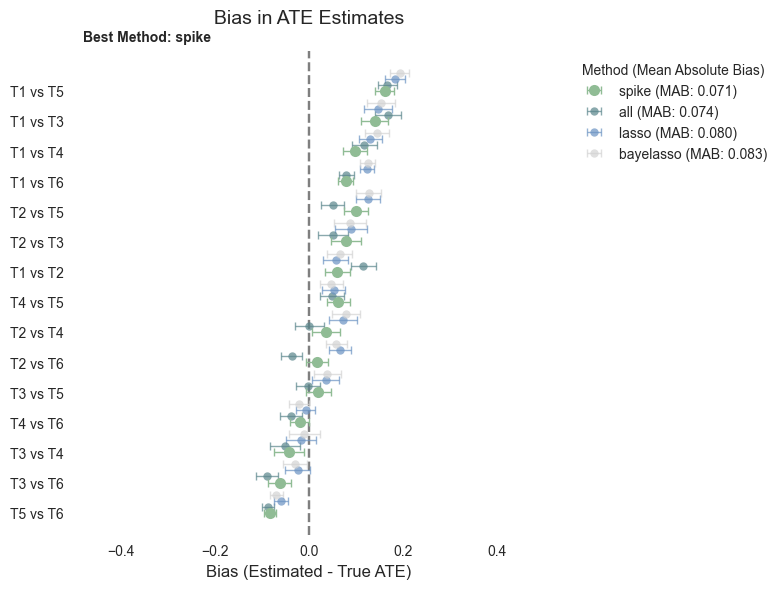

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def load_and_process_data(true_ate_path, methods):
    # Load true ATE values
    true_ate = pd.read_csv(true_ate_path)
    
    # Load estimated ATEs for each method
    estimates = []
    for method in methods:
        df = pd.read_csv(f"./sim_outcome/ate_plot_{method}_summary.csv")
        df['Method'] = method
        estimates.append(df[['Method', 'Treatment1', 'Treatment2', 'ATE', 'CI_Lower', 'CI_Upper']])
    
    estimates_df = pd.concat(estimates, ignore_index=True)
    
    # Merge with true values
    final_df = pd.merge(
        estimates_df,
        true_ate[['Treatment1', 'Treatment2', 'ATE']].rename(columns={'ATE': 'True_ATE'}),
        on=['Treatment1', 'Treatment2']
    )
    
    # Calculate bias
    final_df['Bias'] = final_df['ATE'] - final_df['True_ATE']
    
    # Create treatment comparison labels
    final_df['Comparison'] = 'T' + final_df['Treatment1'].astype(str) + ' vs T' + final_df['Treatment2'].astype(str)
    
    return final_df

def create_bias_plot(data, color_palette):
    # Calculate mean absolute bias for each method
    method_performance = data.groupby('Method')['Bias'].apply(lambda x: np.mean(np.abs(x))).sort_values()
    best_method = method_performance.index[0]
    
    # Create figure with white background
    fig, ax = plt.subplots(figsize=(8, 6))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Calculate mean bias for sorting
    mean_bias = data.groupby('Comparison')['Bias'].mean()
    comparison_order = mean_bias.sort_values(ascending=True).index
    
    # Create y-position mapping
    unique_comparisons = list(comparison_order)
    y_positions = {comp: i for i, comp in enumerate(unique_comparisons)}
    
    # Plot for each method
    for i, method in enumerate(method_performance.index):  # Plot in order of performance
        method_data = data[data['Method'] == method]
        
        # Calculate y positions with offset
        y_vals = [y_positions[comp] + i * 0.2 for comp in method_data['Comparison']]
        
        # Add subtle highlight for best method
        if method == best_method:
            marker_size = 8
            alpha = 1.0
            zorder = 3
        else:
            marker_size = 6
            alpha = 0.7
            zorder = 2
            
        # Plot points and error bars
        plt.errorbar(
            method_data['Bias'],
            y_vals,
            xerr=[(method_data['ATE'] - method_data['CI_Lower']),
                  (method_data['CI_Upper'] - method_data['ATE'])],
            fmt='o',
            color=color_palette[i],
            label=f"{method} (MAB: {method_performance[method]:.3f})",
            capsize=3,
            capthick=1,
            markersize=marker_size,
            elinewidth=1,
            alpha=alpha,
            zorder=zorder
        )
    
    # Add reference line at zero
    plt.axvline(x=0, color='black', linestyle='--', alpha=0.5, zorder=1)
    
    # Set bias axis limits
    plt.xlim(-0.5, 0.5)
    
    # Add subtle grid only for x-axis
    plt.grid(axis='x', linestyle=':', alpha=0.3)
    
    # Customize plot
    plt.yticks(
        range(len(unique_comparisons)),
        [f'T{comp.split()[0][1]} vs T{comp.split()[2][1]}' for comp in unique_comparisons],
        fontsize=10
    )
    
    plt.xlabel('Bias (Estimated - True ATE)', fontsize=12)
    plt.title('Bias in ATE Estimates', fontsize=14, pad=20)
    
    # Add legend with performance metrics
    plt.legend(title='Method (Mean Absolute Bias)', 
              bbox_to_anchor=(1.05, 1), 
              loc='upper left')
    
    # Add annotation for best method
    plt.annotate(f'Best Method: {best_method}',
                xy=(0.02, 1.02),
                xycoords='axes fraction',
                fontsize=10,
                fontweight='bold')
    
    # Adjust layout and margins
    plt.tight_layout()
    
    return plt.gcf()

# Usage
methods = ['all', 'bayelasso', 'lasso', 'spike']
color_palette = ['#90BC95', '#59858B', '#6A92C2', '#D3D3D3']
data = load_and_process_data("./ate.csv", methods)
fig = create_bias_plot(data, color_palette)
plt.savefig('ate_comparison.png', dpi=300, bbox_inches='tight')
plt.show()